In [10]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline 

In [23]:
class Layer:
    def __init__(self, W, b, f):
        self._W = W
        self._b = b
        self._f = f

    def propagate_forward(self, x):
        #return self._f(self._W @ x + self._b)
        return self._f(np.dot(self._W, x) + self._b)


def sigmoid(s):
    return 1/(1 + np.exp(-s))


def d_sigmoid(y):
    return y * (1 - y)


def se(t, y):
    #return ((t - y).T @ (t - y)).flatten()[0] / 2.0
    return np.dot(np.transpose(t-y), t-y).flatten()[0] /2.0


def d_se(t, y):
    return -(t - y)


def ma(history, n):
    return np.array([0, ] * (n - 1) + [np.average(history[i - n: i]) for i in range(n, len(history) + 1)])

100%|██████████| 1000/1000 [00:01<00:00, 817.12it/s]


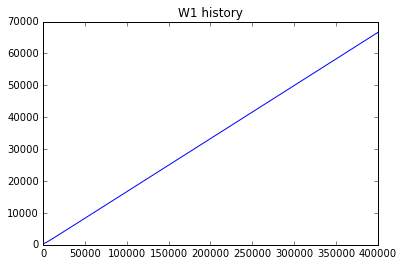

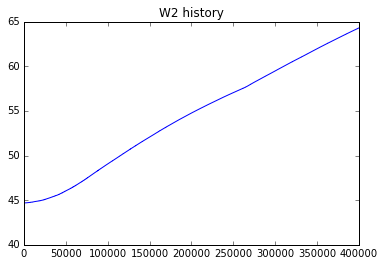

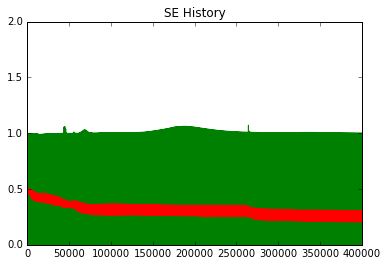

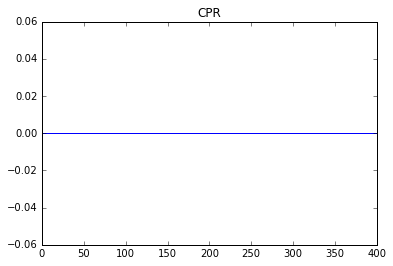

In [29]:
if __name__ == '__main__':
    from mnist import MNIST

    # Load MNIST dataset
    mndata = MNIST('./mnist')
    train_img, train_label = mndata.load_training()
    train_img = np.array(train_img, dtype=float)/255.0
    train_label = np.array(train_label, dtype=float)

    # Input vector (Layer 0)
    n_output_0 = len(train_img[0])

    # Middle layer (Layer 1)
    n_output_1 = 200
    W1 = np.random.randn(n_output_1, n_output_0)
    b1 = np.random.randn(n_output_1, 1)
    layer1 = Layer(W1, b1, sigmoid)

    # Output layer (Layer 2)
    n_output_2 = 10
    W2 = np.random.randn(n_output_2, n_output_1)
    b2 = np.random.randn(n_output_2, 1)
    layer2 = Layer(W2, b2, sigmoid)

    # FP, BP and learning
    epsilon = 0.15
    n_training_data = 1000
    se_history = []
    y1_history = []
    y2_history = []
    W1_history = []
    W2_history = []
    cpr_history = []
    for loop in range(400):
        for i in tqdm(range(n_training_data)):
            # Store W1 and W2 history
            W1_history.append(np.linalg.norm(layer1._W))
            W2_history.append(np.linalg.norm(layer2._W))

            # FP
            x = train_img[i].reshape(len(train_img[i]), 1)
            y1 = layer1.propagate_forward(x)
            y2 = layer2.propagate_forward(y1)

            # Store y1 and y2
            y1_history.append(y1)
            y2_history.append(y2)

            # Training datum
            t = np.zeros(shape=(10, 1))
            t[train_label[i], 0] = 1.0

            # Calculate and store SE
            se_history.append(se(t, y2))

            # BP
            delta2 = d_se(t, y2) * d_sigmoid(y2)
            #delta1 = layer2._W.T @ delta2 * d_sigmoid(y1)
            delta1 = np.dot(np.transpose(layer2._W), delta2) * d_sigmoid(y1)

            # Learning
            #Delta_W2 = delta2 @ y1.T
            Delta_W2 = np.dot(delta2, y1.T)
            layer2._W -= epsilon * Delta_W2
            layer2._b -= epsilon * delta2

            #Delta_W1 = delta1 @ x.T
            Delta_W1 = np.dot(delta, x.T)
            layer1._W -= epsilon * Delta_W1
            layer1._b -= epsilon * delta1

        # FP to evaluate correct prediction rate
        n_correct_prediction = 0
        n_prediction = 0
        for _i in np.random.choice(np.arange(n_training_data, train_img.shape[0]), 100):
            _x = train_img[_i].reshape(len(train_img[_i]), 1)
            _y1 = layer1.propagate_forward(_x)
            _y2 = layer2.propagate_forward(_y1)

            n_prediction += 1
            if train_label[_i] == np.argmax(_y2):
                n_correct_prediction += 1
        cpr_history.append(n_correct_prediction/n_prediction)

    # Draw W1
    plt.figure()
    plt.title('W1 history')
    plt.plot(range(len(W1_history)), W1_history)

    # Draw W2
    plt.figure()
    plt.title('W2 history')
    plt.plot(range(len(W2_history)), W2_history)

    # Draw SE history and its moving average
    plt.figure()
    plt.title('SE History')
    plt.plot(range(len(se_history)), se_history, color='green')
    plt.plot(range(len(se_history)), ma(se_history, 100), color='red')

    # Draw CPR history
    plt.figure()
    plt.title('CPR')
    plt.plot(range(len(cpr_history)), cpr_history)

    plt.show()